<a href="https://colab.research.google.com/github/raghuramkomara2906/Assignment-2---Computational-problem-solving/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Avengers - Assignment 5 - Transfer Learning for Multi-Class Image Classification Using ResNet-50

# 1. Setup & Imports
## Library Imports
- Imported essential libraries for deep learning with PyTorch and torchvision.
- Included tools for data loading, model building, evaluation, and visualization.
- Integrated Weights & Biases (wandb) for tracking training metrics and visualizations.

## Device Configuration
- Automatically detects and sets the device (GPU or CPU) for model training and inference.

## Mount Google Drive
- Google Drive is mounted to access the dataset files stored under a specific path.

## Dataset Path Setup & Verification
- Defined the dataset directory path inside Google Drive.
- Listed files in the dataset directory to verify data availability before proceeding.

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import os
from google.colab import drive
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix,classification_report
import numpy as np
import wandb
import matplotlib.pyplot as plt
import seaborn as sns

#  Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Mount Google Drive
drive.mount('/content/drive')

#  Define dataset path
dataset_path = "/content/drive/MyDrive/Standford_Cars_Dataset/Cars_Dataset/"  # Change this

#  Verify files
print("Dataset Files:", os.listdir(dataset_path))


Mounted at /content/drive
Dataset Files: ['README.md', 'test', 'train']


##  W&B Authentication
- Logs into the Weights & Biases (wandb) platform using the user's API key.
- Enables automatic logging of training metrics, loss curves, and visualizations.
- Essential step for tracking and comparing experiment performance over time.


In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raghuramkomara (usf-avengers) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

##  Experiment Tracking & Configuration (W&B)
- Initializes a new training run using `wandb.init()` with a project name and team entity for collaborative tracking.
- Sets key hyperparameters like:
  - `learning_rate`: Controls the step size during optimization.
  - `num_epochs`: Number of training epochs.
  - `batch_size`: Number of samples per batch.
  - `dropout`: Dropout rate (0 for ResNet-50).
  - `weight_decay`: Regularization parameter to prevent overfitting.
  - `optimizer_choice`: Optimizer used for training.
- Logs all hyperparameters and metadata using `wandb.config.update()` to ensure they are stored and visualized in the W&B dashboard.
- Metadata includes model type, whether pretrained weights were used, and dataset information.

In [ ]:
#  Manually Log a Single Training Run
wandb.init(project="Transfer_Learning_CNN", entity="usf-avengers", reinit=True)

#  Set Hyperparameters
learning_rate = 0.0005
num_epochs = 20
batch_size = 64
dropout = 0.0  # No dropout in ResNet-50 by default
weight_decay = 0.0001
optimizer_choice = "SGD with Momentum"

#  Log Hyperparameters to WandB
wandb.config.update({
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": batch_size,
    "dropout": dropout,
    "weight_decay": weight_decay,
    "optimizer": optimizer_choice,
    "architecture": "ResNet-50",
    "feature_extraction": True,
    "pretrained": True,
    "num_classes": 25,
    "dataset": "Stanford Cars (25-Class Subset)"
})

### Dataset Preparation & Preprocessing

- Defined separate data transformations for training and testing, including random horizontal flip, rotation, color jitter for training data augmentation.
- Normalized input images using standard ImageNet mean and standard deviation values.
- Selected a consistent subset of 25 random classes from the Stanford Cars dataset to reduce complexity and improve training focus.
- Stored and reused selected class names across sessions for reproducibility.
- Filtered out only the selected classes from the full dataset and remapped their labels to a continuous index range (0–24).
- Created PyTorch DataLoaders with appropriate batch size and performance optimizations (`num_workers`, `pin_memory`).

In [ ]:
# ✅ Define Train and Test Paths
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

# ✅ Define Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load Full Dataset
full_train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
full_test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

# ✅ Print Available Classes
print(f"✅ Total Classes in Dataset: {len(full_train_dataset.classes)}")

# ✅ File Path to Save Selected Classes (Keeps them consistent)
selected_classes_file = "/content/drive/MyDrive/selected_classes.txt"

# ✅ Select 25 Random Classes Only If File Doesn't Exist
if not os.path.exists(selected_classes_file):
    selected_classes = random.sample(full_train_dataset.classes, 25)
    # Save selected classes to a file
    with open(selected_classes_file, "w") as f:
        for cls in selected_classes:
            f.write(cls + "\n")
    print(f"✅ Random 25 Classes Selected & Saved: {selected_classes}")
else:
    # ✅ Load previously selected classes
    with open(selected_classes_file, "r") as f:
        selected_classes = [line.strip() for line in f.readlines()]
    print(f"✅ Loaded Previously Selected Classes: {selected_classes}")

# ✅ Convert Selected Class Names to Indices
selected_class_indices = {full_train_dataset.class_to_idx[c]: i for i, c in enumerate(selected_classes)}

# ✅ Filter Train Dataset and Re-map Labels
filtered_train_indices = [i for i, (_, label) in enumerate(full_train_dataset.samples) if label in selected_class_indices]
train_dataset = Subset(full_train_dataset, filtered_train_indices)

# ✅ Filter Test Dataset and Re-map Labels
filtered_test_indices = [i for i, (_, label) in enumerate(full_test_dataset.samples) if label in selected_class_indices]
test_dataset = Subset(full_test_dataset, filtered_test_indices)

# ✅ Custom Dataset Class to Remap Labels
class RemappedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, selected_class_indices):
        self.dataset = original_dataset
        self.class_map = selected_class_indices  # Mapping old class index → new index

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        new_label = self.class_map[label]  # Remap label to range 0-24
        return img, new_label

# ✅ Apply Label Remapping
train_dataset = RemappedDataset(train_dataset, selected_class_indices)
test_dataset = RemappedDataset(test_dataset, selected_class_indices)

# ✅ Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# ✅ Print Final Training Information
num_selected_classes = len(selected_classes)
print(f"✅ Number of Selected Classes for Training: {num_selected_classes}")
print(f"✅ Training Samples: {len(train_dataset)}")
print(f"✅ Testing Samples: {len(test_dataset)}")
print(f"✅ Final Selected Class Names: {selected_classes}")

✅ Total Classes in Dataset: 196
✅ Loaded Previously Selected Classes: ['Ford Ranger SuperCab 2011', 'Jeep Patriot SUV 2012', 'Audi R8 Coupe 2012', 'Mercedes-Benz S-Class Sedan 2012', 'Dodge Dakota Crew Cab 2010', 'Toyota 4Runner SUV 2012', 'Chevrolet HHR SS 2010', 'Dodge Magnum Wagon 2008', 'GMC Canyon Extended Cab 2012', 'Daewoo Nubira Wagon 2002', 'Audi V8 Sedan 1994', 'Ford F-150 Regular Cab 2007', 'Suzuki Aerio Sedan 2007', 'Cadillac SRX SUV 2012', 'Chevrolet Monte Carlo Coupe 2007', 'Dodge Challenger SRT8 2011', 'Aston Martin V8 Vantage Convertible 2012', 'Audi 100 Sedan 1994', 'Hyundai Veracruz SUV 2012', 'Audi TT RS Coupe 2012', 'Honda Accord Coupe 2012', 'Mazda Tribute SUV 2011', 'Chevrolet Express Van 2007', 'Bentley Arnage Sedan 2009', 'Mercedes-Benz E-Class Sedan 2012']
✅ Number of Selected Classes for Training: 25
✅ Training Samples: 1031
✅ Testing Samples: 1024
✅ Final Selected Class Names: ['Ford Ranger SuperCab 2011', 'Jeep Patriot SUV 2012', 'Audi R8 Coupe 2012', 'Merce

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Exploratory Data Analysis (EDA)

- Performed an initial analysis of the full training dataset to inspect the distribution of classes.
- Counted the number of samples per class using `Counter` and mapped them to class names for readability.
- The class distribution was visualized using a bar chart.
- This helped identify whether the dataset suffers from class imbalance issues, which can impact model performance and fairness.


AM General Hummer SUV 2000: 45 samples
Acura Integra Type R 2001: 45 samples
Acura RL Sedan 2012: 32 samples
Acura TL Sedan 2012: 43 samples
Acura TL Type-S 2008: 42 samples
Acura TSX Sedan 2012: 41 samples
Acura ZDX Hatchback 2012: 39 samples
Aston Martin V8 Vantage Convertible 2012: 45 samples
Aston Martin V8 Vantage Coupe 2012: 41 samples
Aston Martin Virage Convertible 2012: 33 samples
Aston Martin Virage Coupe 2012: 38 samples
Audi 100 Sedan 1994: 41 samples
Audi 100 Wagon 1994: 43 samples
Audi A5 Coupe 2012: 41 samples
Audi R8 Coupe 2012: 43 samples
Audi RS 4 Convertible 2008: 37 samples
Audi S4 Sedan 2007: 45 samples
Audi S4 Sedan 2012: 40 samples
Audi S5 Convertible 2012: 42 samples
Audi S5 Coupe 2012: 43 samples
Audi S6 Sedan 2011: 46 samples
Audi TT Hatchback 2011: 41 samples
Audi TT RS Coupe 2012: 40 samples
Audi TTS Coupe 2012: 43 samples
Audi V8 Sedan 1994: 44 samples
BMW 1 Series Convertible 2012: 36 samples
BMW 1 Series Coupe 2012: 41 samples
BMW 3 Series Sedan 2012: 43 

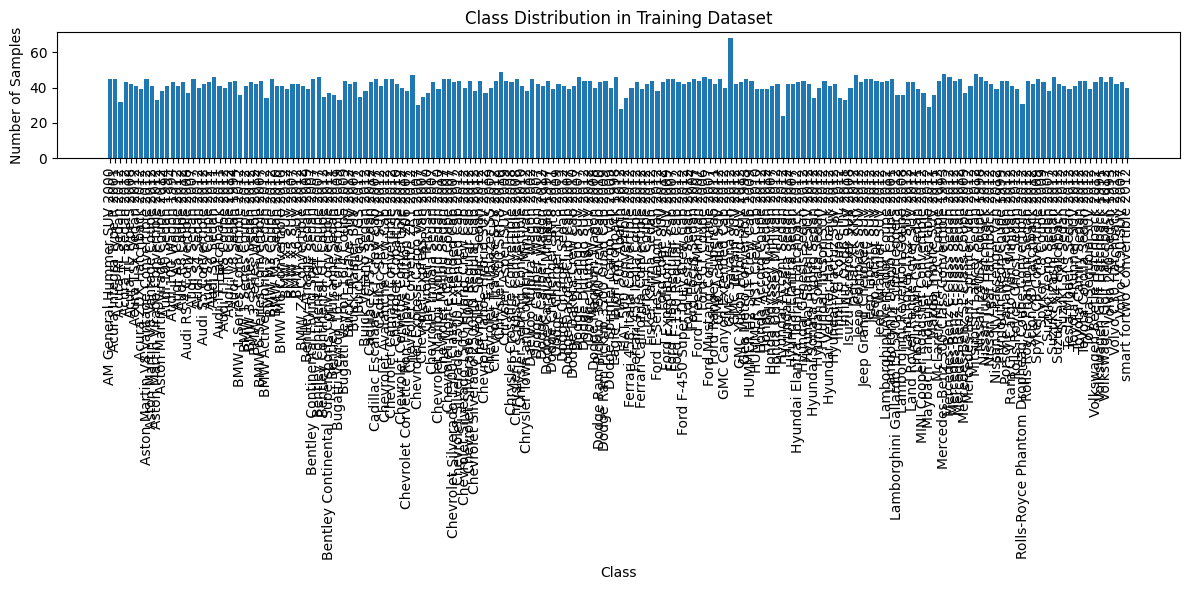

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Extract class indices from the dataset
train_labels = [label for _, label in full_train_dataset.samples]

# Count the frequency of each class index
class_counts = Counter(train_labels)

# Map class indices to class names
idx_to_class = {v: k for k, v in full_train_dataset.class_to_idx.items()}
class_names = [idx_to_class[idx] for idx in class_counts.keys()]
counts = list(class_counts.values())

# Print
for name, count in zip(class_names, counts):
    print(f"{name}: {count} samples")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(class_names, counts)
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

### Handling Class Imbalance

- To address potential class imbalance, we computed class weights using `sklearn`'s `compute_class_weight` method.
- These weights help balance the loss contribution from each class, ensuring the model doesn’t get biased toward majority classes.
- The computed class weights were passed into `nn.CrossEntropyLoss`, effectively enabling **weighted loss-based training**.
- Below is the class distribution and the corresponding weights computed for each class:

**Example Output:**
- Class 0 → 42 samples, Weight: 0.9819  
- Class 1 → 44 samples, Weight: 0.9373  
*(…continues for all 25 classes…)*


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_counts = [0] * 25
for _, label in train_dataset:
    class_counts[label] += 1
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(list(selected_class_indices.values())), y=[label for _, label in train_dataset])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# 🔍 Count class frequencies
from collections import Counter
label_list = [label for _, label in train_dataset]
class_distribution = Counter(label_list)
print("🔹 Class Distribution:")
for cls_idx in sorted(class_distribution):
    print(f"Class {cls_idx} → {class_distribution[cls_idx]} samples")

# 🔍 Show computed class weights
print("\n🔹 Computed Class Weights (for loss function):")
for i, w in enumerate(class_weights.cpu().numpy()):
    print(f"Class {i} → Weight: {w:.4f}")

🔹 Class Distribution:
Class 0 → 42 samples
Class 1 → 44 samples
Class 2 → 43 samples
Class 3 → 45 samples
Class 4 → 41 samples
Class 5 → 41 samples
Class 6 → 37 samples
Class 7 → 40 samples
Class 8 → 40 samples
Class 9 → 45 samples
Class 10 → 44 samples
Class 11 → 45 samples
Class 12 → 38 samples
Class 13 → 41 samples
Class 14 → 45 samples
Class 15 → 39 samples
Class 16 → 45 samples
Class 17 → 41 samples
Class 18 → 42 samples
Class 19 → 40 samples
Class 20 → 39 samples
Class 21 → 36 samples
Class 22 → 35 samples
Class 23 → 39 samples
Class 24 → 44 samples

🔹 Computed Class Weights (for loss function):
Class 0 → Weight: 0.9819
Class 1 → Weight: 0.9373
Class 2 → Weight: 0.9591
Class 3 → Weight: 0.9164
Class 4 → Weight: 1.0059
Class 5 → Weight: 1.0059
Class 6 → Weight: 1.1146
Class 7 → Weight: 1.0310
Class 8 → Weight: 1.0310
Class 9 → Weight: 0.9164
Class 10 → Weight: 0.9373
Class 11 → Weight: 0.9164
Class 12 → Weight: 1.0853
Class 13 → Weight: 1.0059
Class 14 → Weight: 0.9164
Class 15 → 

### Model Architecture & Transfer Learning Strategy

We used the ResNet-50 architecture pre-trained on ImageNet as our base model. This approach leverages rich feature representations learned on a large and diverse dataset.

Our transfer learning strategy included:
- **Freezing all convolutional layers** to retain previously learned features.
- **Unfreezing `layer4`**, the final block of convolutional layers, to allow for partial fine-tuning. This helps the model adapt higher-level features to the specific characteristics of the Stanford Cars dataset.
- **Replacing the final fully connected (fc) layer** to output predictions for 25 classes, matching the subset of classes we selected from the dataset.
- The final model was moved to the GPU using `model.to(device)` to enable faster training.


In [ ]:
# ✅ Load Pre-trained ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# ✅ Freeze All Layers
for param in model.parameters():
    param.requires_grad = False

# ✅ Unfreeze layer4
for param in model.layer4.parameters():
    param.requires_grad = True

# ✅ Replace Final Layer
num_classes = 25
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ✅ Ensure Final Layer is Trainable
for param in model.fc.parameters():
    param.requires_grad = True

# ✅ Move Model to GPU
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


### Loss Function & Optimization Strategy

To mitigate the impact of class imbalance in our dataset, we computed class-specific weights using scikit-learn’s `compute_class_weight` method. These weights were integrated into the `CrossEntropyLoss`, ensuring that underrepresented classes contributed more to the loss during training.

For optimization, we selected **Stochastic Gradient Descent (SGD) with Momentum**:
- **Learning Rate:** 0.0005
- **Momentum:** 0.9
- **Weight Decay:** 0.0001

We also used the **`ReduceLROnPlateau`** learning rate scheduler, which reduces the learning rate by a factor of 0.3 if the validation loss doesn't improve for 3 consecutive epochs, allowing for adaptive learning rate decay during training.


In [ ]:
# ✅ Define Loss Function & Optimizer
from sklearn.utils.class_weight import compute_class_weight

labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Model Training, Evaluation, and Logging

We developed a custom training function to handle the end-to-end training and evaluation of our modified ResNet-50 model. The function supports:

- **Training Loop:** Standard forward and backward passes with parameter updates using backpropagation.
- **Validation Evaluation:** Each epoch includes evaluation on the validation set, collecting predictions and calculating metrics such as accuracy, precision, recall, and F1-score using `scikit-learn`.
- **W&B Logging:** All relevant metrics, including loss values and classification scores, are logged to Weights & Biases. This facilitates real-time experiment tracking and comparison across multiple runs.
- **Confusion Matrix:** A confusion matrix is generated for each epoch to visualize class-wise prediction performance.
- **Class-wise Metrics:** Per-class precision, recall, and F1 scores are computed and logged to track individual class behavior over time.
- **Sample Predictions:** A snapshot of 20 predicted validation images is logged to W&B to qualitatively inspect model predictions.
- **Model Versioning:** After training, the model is saved and logged as a versioned artifact in W&B, enabling reproducibility and rollback to previous models.

This detailed tracking helps assess model performance and ensures traceability for all training experiments.


In [ ]:
# ✅ Training & Evaluation Function
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, num_epochs, scheduler=None):
    train_losses, val_losses = [] ,[]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation Phase
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        sample_images, sample_preds = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                if len(sample_images) < 20:
                    sample_images.extend(images.cpu())
                    sample_preds.extend(preds.cpu())

        val_losses.append(val_loss / len(val_loader))

        # Compute Metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # ✅ Log Metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_losses[-1],
            "val_loss": val_losses[-1],
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        })

        # ✅ Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title("Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        wandb.log({"confusion_matrix": wandb.Image(fig)})
        plt.close(fig)

        # ✅ Per-Class Metrics
        report = classification_report(all_labels, all_preds, output_dict=True)
        for class_idx, metrics in report.items():
            if class_idx.isdigit():
                class_name = selected_classes[int(class_idx)]
                wandb.log({
                    f"{class_name}/precision": metrics["precision"],
                    f"{class_name}/recall": metrics["recall"],
                    f"{class_name}/f1_score": metrics["f1-score"]
                })

        # ✅ Sample Predictions
        predictions_table = []
        for img, pred in zip(sample_images[:20], sample_preds[:20]):
            predictions_table.append(wandb.Image(img, caption=f"Predicted: {selected_classes[pred]}"))
        wandb.log({"sample_predictions": predictions_table})

        if scheduler:
            scheduler.step(val_losses[-1])

    # Plot Loss Curve
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve - Training vs Validation")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ✅ Save and log model as artifact (versioned)
    model_path = "resnet50_transfer.pth"
    torch.save(model.state_dict(), model_path)
    artifact = wandb.Artifact("resnet50-transfer-model", type="model")
    artifact.add_file(model_path)
    artifact.alias = [f"v{wandb.run.step}"]
    wandb.log_artifact(artifact)

# ✅ Train the Model
train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, num_epochs, scheduler)

# ✅ Finish WandB Run
wandb.finish()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 